In [1]:
# This file generates the data for Figure #4 from the paper https://arxiv.org/pdf/1806.06975.pdf
import sys
sys.path.append('../')

import os
import sys
import pickle
import argparse
import networkx as nx

import pandas as pd
import numpy as np

import itertools
import sklearn
import torch
import datetime
import matplotlib, matplotlib.pyplot as plt

from torch.autograd import Variable

from models.mlp import MLP
from data import datasets
from data.gene_graphs import GeneManiaGraph, RegNetGraph
from data.utils import record_result

In [2]:
dataset = datasets.TCGADataset()
dataset.df = dataset.df - dataset.df.mean(axis=0)

Converting one-hot labels to integers


In [3]:
graphs = {"regnet": RegNetGraph(), "genemania": GeneManiaGraph()}


In [4]:
# Setup the results dictionary
filename = "../experiments/results/fig-4.pkl"
try:
    results = pickle.load(open(filename, "rb"), encoding='latin1')
    print("Loaded Checkpointed Results")
except Exception as e:
    print(e)
    results = pd.DataFrame(columns=['auc', 'gene', 'model', 'graph', 'is_first_degree', 'seed', 'train_size'])
    print("Created a New Results Dictionary")


Loaded Checkpointed Results


In [6]:
train_size = 50
test_size = 1000
trials = 3
cuda = torch.cuda.is_available()
models = {"BasicMLP": MLP(column_names=dataset.df.columns, dropout=False, cuda=cuda)}


Early stopping metric is accuracy_score


In [7]:
# Create the set of all experiment ids and see which are left to do
columns = ["gene", "graph", "model", "seed", "is_first_degree", "train_size"]
all_exp_ids = [x for x in itertools.product(dataset.df.columns, graphs.keys(), models.keys(), range(trials), [True, False], [train_size])]
all_exp_ids = pd.DataFrame(all_exp_ids, columns=columns)
all_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in all_exp_ids.itertuples(name=None)]
results_exp_ids = results[columns].copy()
results_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in results_exp_ids.itertuples(name=None)]
intersection_ids = all_exp_ids.index.intersection(results_exp_ids.index)
todo = all_exp_ids.drop(intersection_ids).to_dict(orient="records")

print("todo: " + str(len(todo)))
print("done: " + str(len(results)))

todo: 195582
done: 33


In [10]:
for row in todo:
    if len(results) % 10 == 0:
        print(len(results))
    gene = row["gene"]
    graph_name = row["graph"]
    model_name = row["model"]
    seed = row["seed"]
    is_first_degree = row["is_first_degree"]
    model = models[model_name]

    experiment = {
        "gene": gene,
        "model": model_name,
        "graph": graph_name,
        "is_first_degree": is_first_degree,
        "seed": seed,
        "train_size": train_size,
    }
    dataset.labels = dataset.df[gene].where(dataset.df[gene] > 0).notnull().astype("int")
    dataset.labels = dataset.labels.values if type(dataset.labels) == pd.Series else dataset.labels

    try:
        X_train, X_test, y_train, y_test = sklearn.model_selection.\
            train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, 
                             train_size=train_size, test_size=test_size)
    except ValueError:
        results = record_result(results, experiment, filename)
        continue
    if is_first_degree:
        gene_graph = graphs[graph_name]
        neighbors = list(gene_graph.first_degree(gene)[0])
        neighbors = [n for n in neighbors if n in X_train.columns.values]
        X_train = X_train.loc[:, neighbors].copy()
        X_test = X_test.loc[:, neighbors].copy()
    else:
        X_train = X_train.copy()
        X_test = X_test.copy()
    X_train[gene] = 1
    X_test[gene] = 1
    try:
        model.fit(X_train, y_train)
        if cuda:
            X_test = X_test.cuda()
        y_hat = model.predict(X_test)
        auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())
        model.best_model = None # cleanup
        experiment["auc"] = auc
    except Exception as e:
        print(e)
    results = record_result(results, experiment, filename)


  batch (0/40), train loss:0.7389
  batch (10/40), train loss:0.7404
  batch (20/40), train loss:0.6998
  batch (30/40), train loss:0.7252
epoch: 0, time: 0.00, valid_metric: 0.40, train_metric: 0.35
  batch (0/40), train loss:0.7368
  batch (10/40), train loss:0.7388
  batch (20/40), train loss:0.6981
  batch (30/40), train loss:0.7242
epoch: 1, time: 0.00, valid_metric: 0.40, train_metric: 0.35
  batch (0/40), train loss:0.7353
  batch (10/40), train loss:0.7374
  batch (20/40), train loss:0.6965
  batch (30/40), train loss:0.7232
epoch: 2, time: 0.00, valid_metric: 0.40, train_metric: 0.35
  batch (0/40), train loss:0.7338
  batch (10/40), train loss:0.7360
  batch (20/40), train loss:0.6949
  batch (30/40), train loss:0.7221
epoch: 3, time: 0.00, valid_metric: 0.40, train_metric: 0.38
  batch (0/40), train loss:0.7323
  batch (10/40), train loss:0.7347
  batch (20/40), train loss:0.6933
  batch (30/40), train loss:0.7209
epoch: 4, time: 0.00, valid_metric: 0.40, train_metric: 0.38


KeyboardInterrupt: 

In [ ]:
# Compare the performance of each graph at predicting their neighbors
df = results

first_degree = df[df['is_first_degree'] == True][
    df['graph'] == 'genemania'].groupby(['gene', 'model', 'train_size'])['auc'].agg(['mean', 'std'])
full = df[df['is_first_degree'] == False][
    df['graph'] == 'genemania'].groupby(['gene','model', 'train_size'])['auc'].agg(['mean', 'std'])
genemania_df = first_degree.sub(full).sort_values('mean', ascending=False)

first_degree = df[df['is_first_degree'] == True][
    df['graph'] == 'regnet'].groupby(['gene', 'model', 'train_size'])['auc'].agg(['mean', 'std'])
full = df[df['is_first_degree'] == False][
    df['graph'] == 'regnet'].groupby(['gene','model', 'train_size'])['auc'].agg(['mean', 'std'])
regnet_df = first_degree.sub(full).sort_values('mean', ascending=False)


/home/martin/code/academic/gene-graph-conv/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/martin/code/academic/gene-graph-conv/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


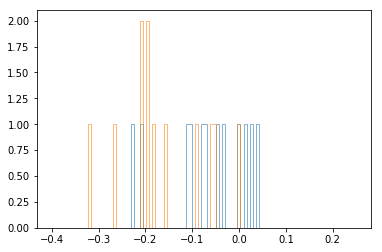

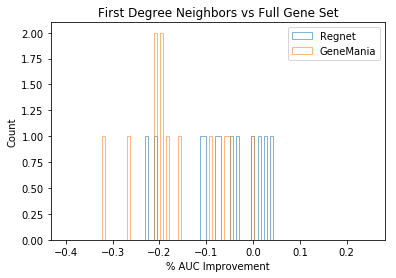

In [9]:

l1 = genemania_df['mean']
l2 = regnet_df['mean']

fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, range=(-.4, .25), bins=100, label="Regnet", 
                              density=0, alpha=0.55, histtype='step')
n1, bins1, patches1 = ax.hist(l2, range=(-.4, .25), bins=100, label="GeneMania", 
                              density=0, alpha=0.55, histtype='step')


fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, range=(-.4, .25), bins=100, label="Regnet", 
                              density=0, alpha=0.55, histtype='step')
n1, bins1, patches1 = ax.hist(l2, range=(-.4, .25), bins=100, label="GeneMania", 
                              density=0, alpha=0.55, histtype='step')

plt.title("First Degree Neighbors vs Full Gene Set")
plt.ylabel("Count")
plt.xlabel("% AUC Improvement")

plt.legend()
plt.show()